In [1]:
import pandas as pd
import seaborn as sns
import time, pickle

from zipfile import ZipFile

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt
import numpy as np



from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              AdaBoostClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier)
from xgboost import XGBClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import auc
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")



In [2]:
z = ZipFile("data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
data_train.shape

(307511, 309)

In [3]:
TARGET = pd.read_csv('TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 309), (92254, 309), (215257, 1), (92254, 1))

### **Baseline model - Logistic Regression**
Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [6]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="",cmap='YlGnBu')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()


In [7]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6939
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

CPU times: user 15 s, sys: 750 ms, total: 15.7 s
Wall time: 2.28 s


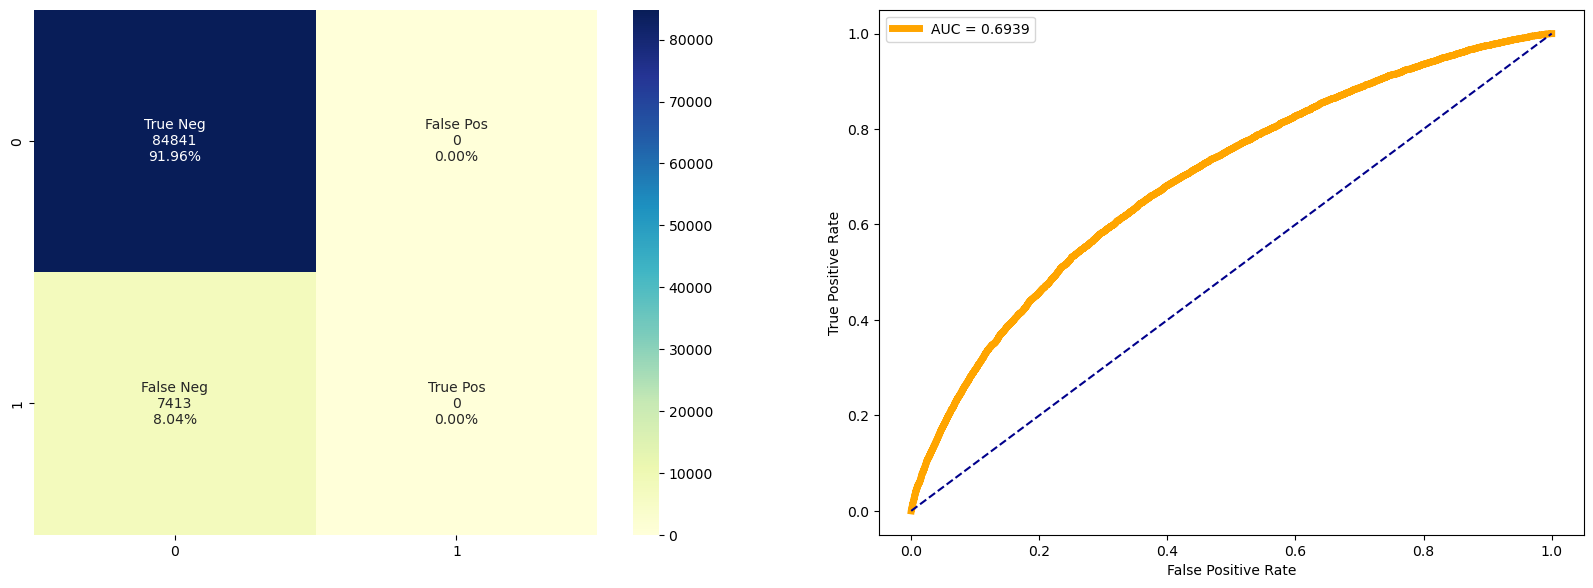

In [8]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français)  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

In [9]:
# Pipeline de standardisation et d'imputation des valeurs manquantes
var_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),])

## Ici nous allons tester plusieurs modeles pour choisir les plus performants

In [10]:


base_estim = DecisionTreeClassifier(random_state=0) 
# Dictionnaire de classifieurs 
classifiers_1 = { 'Dummy Classifier': DummyClassifier(),
                  'Logistic Regression': LogisticRegression(n_jobs=-1,C = 0.0001, max_iter=100),
                  'Random Forest': RandomForestClassifier(n_jobs=-1),
                  'Multi-layer Perceptron': MLPClassifier(),
                  'Xgboost': XGBClassifier(n_jobs=-1),
                  'LGBM':LGBMClassifier(n_jobs=-1,silent=-1,verbose=-1),
                  'adaBoost':AdaBoostClassifier(base_estimator=base_estim),
                  'hgbm': HistGradientBoostingClassifier(max_iter=500),
                  'gbm' : GradientBoostingClassifier(n_estimators=10),
                  'CatBoostC': CatBoostClassifier( logging_level='Silent'),
                 
                }
                      

In [11]:
# Pipeline de transformations + classification
def define_pipeline(preprocessor, classifier) :
    
    pipe = Pipeline([("regressor", classifier),])
                     
                    
    return pipe


In [12]:
def plot_roc_curve(classifiers, var_pipeline, X, y, n_splits=10, fit=True):
    '''An ROC curve (receiver operating characteristic curve) is a graph showing 
    the performance of a classification model at all classification thresholds.'''
    
    plt.figure(figsize=(10,10))
    kf = KFold(n_splits=n_splits)    
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):

            full_pipeline = define_pipeline(var_pipeline, clf)
            
            X = pd.DataFrame(X)
            y = pd.DataFrame(y)
            
            
            
            if fit :
                full_pipeline.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = full_pipeline.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)

            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        
       
        
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=5,
            alpha=.8)
        

    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Dummy Classifier
Logistic Regression
Random Forest
Multi-layer Perceptron
Xgboost
LGBM
adaBoost
hgbm
gbm
CatBoostC


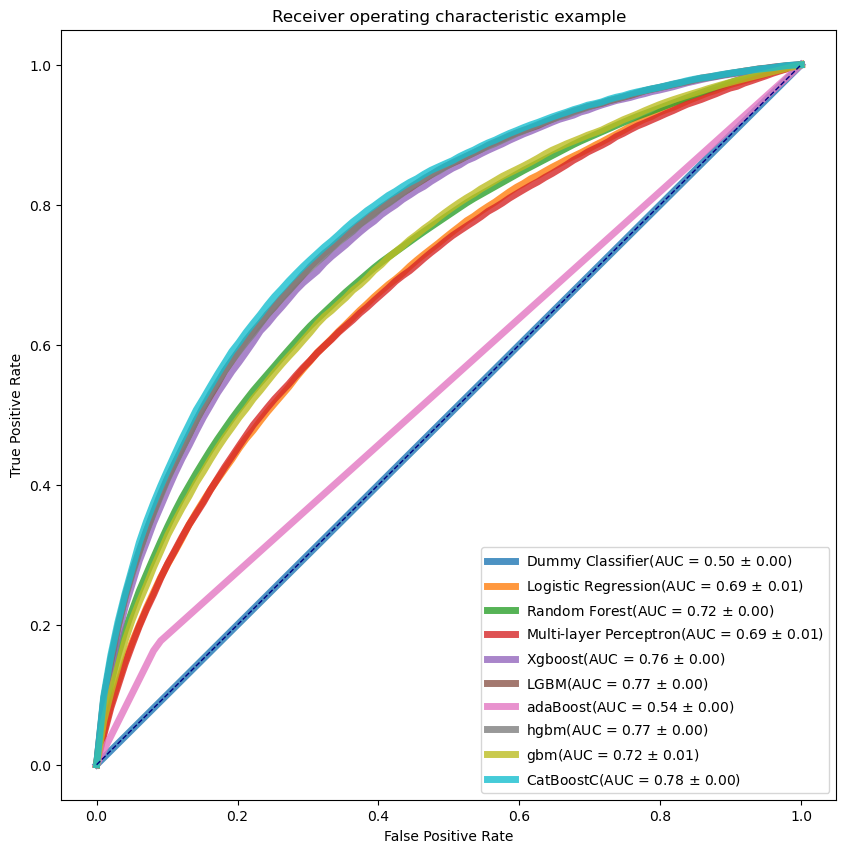

In [13]:
# Affichage de la courbe ROC pour les différents modèles testés
plot_roc_curve(classifiers_1, var_pipeline, X_train, y_train)

### **Oversampling Data Using SMOTE**

SMOTE with Imbalance Data using imblearn module



In [14]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: [17412] 
Label 0, Before using SMOTE: [197845] 


In [15]:
%%time
sm = SMOTE(random_state=43)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
X_test_res, y_test_res = sm.fit_resample( X_test, y_test)

CPU times: user 14.7 s, sys: 1.86 s, total: 16.5 s
Wall time: 2.89 s


In [16]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


In [17]:
print("Label 1, After using SMOTE for test data: {}".format(sum(y_test_res==1)))
print("Label 0, After using SMOTE for test data: {}".format(sum(y_test_res==0)))

Label 1, After using SMOTE for test data: 84841
Label 0, After using SMOTE for test data: 84841


**Testons les données equillibrées en utilisant le LogisticRegression**

In [18]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test_res, lr.predict_proba(X_test_res)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test_res, lr.predict(X_test_res)))

AUC : 0.7530
              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68     84841
         1.0       0.68      0.70      0.69     84841

    accuracy                           0.69    169682
   macro avg       0.69      0.69      0.69    169682
weighted avg       0.69      0.69      0.69    169682

CPU times: user 49.8 s, sys: 1.07 s, total: 50.9 s
Wall time: 6.58 s


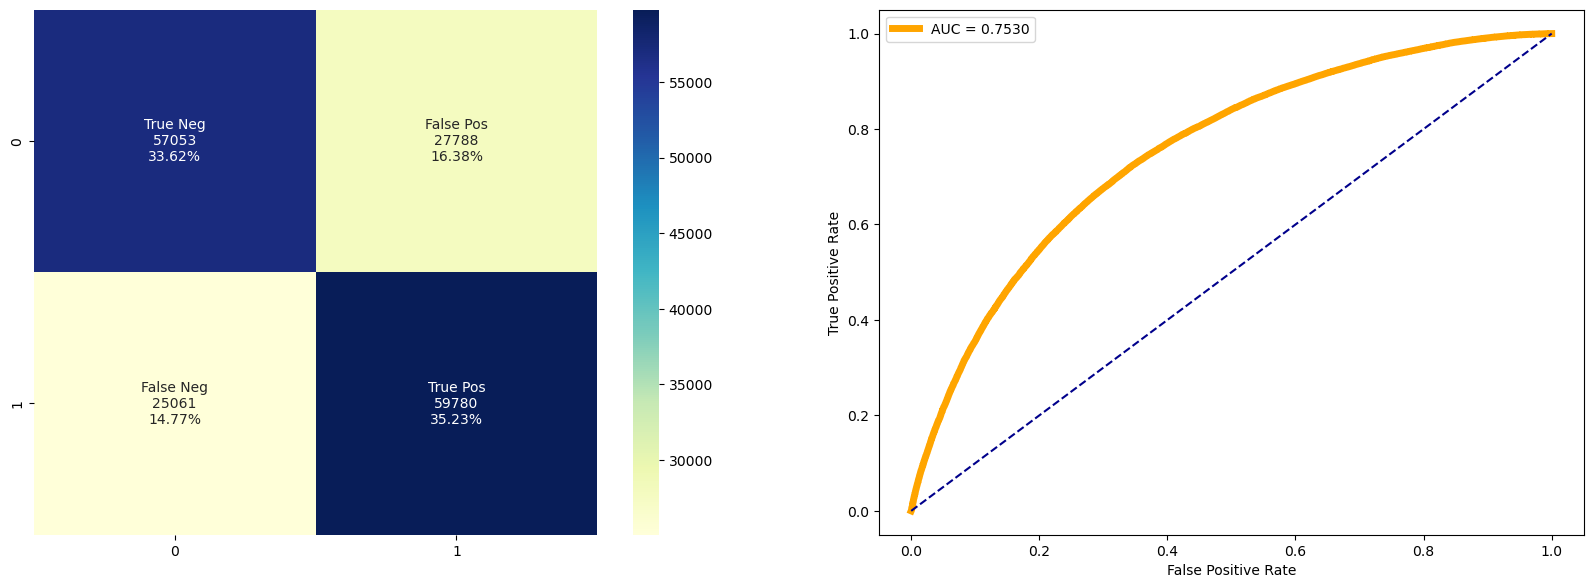

In [19]:
cf_matrix_roc_auc(lr, y_test_res, lr.predict(X_test_res),
                  lr.predict_proba(X_test_res)[:,1], feature_importances=None)

Amélioration de l'AUC score 0.72 que nous prendrons comme baseline de travail pour la suite des essais…

### Ici, nous allons utiliser les modèles choisis les plus performants et nous allons les tester sur les données équilibrées.

In [20]:
#Best performing model based on AUC score 
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [LGBMClassifier(n_jobs=-1),
          HistGradientBoostingClassifier(),
          CatBoostClassifier( logging_level='Silent'),
          XGBClassifier(n_jobs=-1),]

La fonction suivante ``train_models`` peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux [Scoring de Classification de Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [21]:
def train_models(model, X_train_res, X_test_res, y_train_res, y_test_res):
    model.fit(X_train_res, y_train_res)
    output = {
      'AUC': roc_auc_score(y_test_res, model.predict_proba(X_test_res)[:,1]),
      'Accuracy': accuracy_score(y_test_res, model.predict(X_test_res)),
      'Precision': precision_score(y_test_res, model.predict(X_test_res)),
      'Recall': recall_score(y_test_res, model.predict(X_test_res)),
      'F1': f1_score(y_test_res, model.predict(X_test_res))
      }
          
    return output

In [22]:
from sklearn.metrics import f1_score

In [23]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('Time', ascending=True, inplace=True)

CPU times: user 13min 10s, sys: 27.3 s, total: 13min 38s
Wall time: 2min 11s


In [24]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.774506,0.920134,0.55102,0.03278,0.061879,4.700794
1,HistGradientBoostingClassifier,0.775433,0.919808,0.516411,0.031836,0.059975,16.959265
3,XGBClassifier,0.770294,0.919006,0.466363,0.055173,0.098673,51.616074
2,CatBoostClassifier,0.778676,0.919732,0.505731,0.047619,0.087042,58.247414


Nous allons comparer une nouvelle fois nos modèles, cette fois-ci l'entrainement se fera avec les données SMOTE.

In [25]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_res, X_test_res, y_train_res, y_test_res)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1',  'Time']
models_res.sort_values('Time', ascending=True, inplace=True)

CPU times: user 33min 31s, sys: 45.9 s, total: 34min 17s
Wall time: 5min 8s


In [26]:
models_res

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.978357,0.955422,0.997476,0.913155,0.953455,9.920226
1,HistGradientBoostingClassifier,0.978099,0.954609,0.996972,0.911988,0.952588,32.821708
3,XGBClassifier,0.978481,0.95534,0.993397,0.916774,0.953549,130.300266
2,CatBoostClassifier,0.979998,0.955841,0.99516,0.916137,0.954015,135.26279


LGBMClassifier reste le "plus performant" selon le couple métrique/temps.

### Ici considerons dabord les données  smoté

### **Feature Selection - Recursive Feature Elimination**
Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec ``LGBMClassifier`` qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [27]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(n_splits=10), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train_res, y_train_res)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 309 features.
Fitting estimator with 304 features.
Fitting estimator with 299 features.
Fitting estimator with 294 features.
Fitting estimator with 289 features.
Fitting estimator with 284 features.
Fitting estimator with 279 features.
Fitting estimator with 274 features.
Fitting estimator with 269 features.
Fitting estimator with 264 features.
Fitting estimator with 259 features.
Fitting estimator with 254 features.
Fitting estimator with 249 features.
Fitting estimator with 244 features.
Fitting estimator with 239 features.
Fitting estimator with 234 features.
Fitting estimator with 229 features.
Fitting estimator with 224 features.
Fitting estimator with 219 features.
Fitting estimator with 214 features.
Fitting estimator with 209 features.
Fitting estimator with 204 features.
Fitting estimator with 199 features.
Fitting estimator with 194 features.
Fitting estimator with 189 features.
Fitting estimator with 184 features.
Fitting estimator with 179 features.
F

Fitting estimator with 309 features.
Fitting estimator with 304 features.
Fitting estimator with 299 features.
Fitting estimator with 294 features.
Fitting estimator with 289 features.
Fitting estimator with 284 features.
Fitting estimator with 279 features.
Fitting estimator with 274 features.
Fitting estimator with 269 features.
Fitting estimator with 264 features.
Fitting estimator with 259 features.
Fitting estimator with 254 features.
Fitting estimator with 249 features.
Fitting estimator with 244 features.
Fitting estimator with 239 features.
Fitting estimator with 234 features.
Fitting estimator with 229 features.
Fitting estimator with 224 features.
Fitting estimator with 219 features.
Fitting estimator with 214 features.
Fitting estimator with 209 features.
Fitting estimator with 204 features.
Fitting estimator with 199 features.
Fitting estimator with 194 features.
Fitting estimator with 189 features.
Fitting estimator with 184 features.
Fitting estimator with 179 features.
F

Fitting estimator with 309 features.
Fitting estimator with 304 features.
Fitting estimator with 299 features.
Fitting estimator with 294 features.
Fitting estimator with 289 features.
Fitting estimator with 284 features.
Fitting estimator with 279 features.
Fitting estimator with 274 features.
Fitting estimator with 269 features.
Fitting estimator with 264 features.
Fitting estimator with 259 features.
Fitting estimator with 254 features.
Fitting estimator with 249 features.
Fitting estimator with 244 features.
Fitting estimator with 239 features.
Fitting estimator with 234 features.
Fitting estimator with 229 features.
Fitting estimator with 224 features.
Fitting estimator with 219 features.
Fitting estimator with 214 features.
Fitting estimator with 209 features.
Fitting estimator with 204 features.
Fitting estimator with 199 features.
Fitting estimator with 194 features.
Fitting estimator with 189 features.
Fitting estimator with 184 features.
Fitting estimator with 179 features.
F

In [28]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 119


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1…

In [29]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

119
['NAME_CONTRACT_TYPE', 'PREV_APPL_MEAN_HOUR_APPR_PROCESS_START', 'PREV_APPL_MEAN_RATE_DOWN_PAYMENT', 'PREV_APPL_MEAN_DAYS_DECISION', 'PREV_APPL_MEAN_SELLERPLACE_AREA', 'PREV_APPL_MEAN_CNT_PAYMENT', 'PREV_APPL_MEAN_DAYS_FIRST_DRAWING', 'PREV_APPL_MEAN_DAYS_FIRST_DUE', 'PREV_APPL_MEAN_AMT_GOODS_PRICE', 'PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 'PREV_APPL_MEAN_DAYS_TERMINATION', 'PREV_APPL_MEAN_NFLAG_INSURED_ON_APPROVAL', 'PREV_APPL_MEAN_CARD_MEAN_MONTHS_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_CREDIT_LIMIT_ACTUAL', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_ATM_CURRENT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_DRAWINGS_POS_CURRENT', 'PREV_APPL_MEAN_DAYS_LAST_DUE', 'PREV_APPL_MEAN_CARD_MEAN_AMT_PAYMENT_TOTAL_CURRENT', 'PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 'PREVIOUS_APPLICATION_COUNT', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'PREVIOUS_LOANS_COUNT', 'PREV_BUR_MEAN_DAYS_CREDIT', 'PREV_BU

RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également le plot ci-dessus.

In [30]:
#X_data is very important to implement the feature importance plot...
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307511, 119)

Il est nécessaire de sauvegarder le dataset ``X_data`` de manière à pouvoir le réutiliser facilement…

In [31]:
#Merge operation with TARGET before save this reduced sample
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [32]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('X_data.zip', index=True, compression=compression_opts)

CPU times: user 27.6 s, sys: 361 ms, total: 27.9 s
Wall time: 28 s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 149 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [33]:
%%time
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('X_sample.zip', index=True, compression=compression_opts)

CPU times: user 2.73 s, sys: 92.8 ms, total: 2.82 s
Wall time: 2.84 s


In [34]:
%%time
X_data.sample(10000).to_csv('X_sample.csv', index=True)

CPU times: user 467 ms, sys: 14.9 ms, total: 482 ms
Wall time: 483 ms


In [35]:
#Transform data with rfecv 
X_train_selected = rfecv.transform(X_train_res)
X_test_selected = rfecv.transform(X_test_res)

In [36]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Ensemble methods
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }
          
    return output

In [37]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train_res, y_test_res)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('Time', ascending=True, inplace=True)

CPU times: user 14min 30s, sys: 52.5 s, total: 15min 23s
Wall time: 2min 14s


In [38]:
#Models performance with features selection
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.978504,0.955422,0.997553,0.913084,0.953452,8.43859
1,HistGradientBoostingClassifier,0.978063,0.954332,0.996522,0.911847,0.952306,15.811405
2,CatBoostClassifier,0.979841,0.955835,0.994945,0.916326,0.954018,50.150768
3,XGBClassifier,0.978727,0.955146,0.993054,0.916703,0.953352,60.513663


In [39]:
#Reminder before… features selection
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,LGBMClassifier,0.774506,0.920134,0.55102,0.03278,0.061879,4.700794
1,HistGradientBoostingClassifier,0.775433,0.919808,0.516411,0.031836,0.059975,16.959265
3,XGBClassifier,0.770294,0.919006,0.466363,0.055173,0.098673,51.616074
2,CatBoostClassifier,0.778676,0.919732,0.505731,0.047619,0.087042,58.247414


**LGBMClassifier reste le modèle le plus performant selon le couple AUC score/Time.** CatBoostClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel. XGBClassifier est très rapide, il est en effet plus rapide que le LGBMClassifier mais avec une baisse de l'AUC score.

----
Dans la dernière partie de l'étude on développera les 3 volets suivants : **_La fonction coût, l'algorithme d'optimisation et la métrique d'évaluation._**

### **La fonction coût sera déterminée par l'analyse des erreurs de prédiction**

**FP (False Positive) :** les cas où la prédiction est positive, mais où la valeur réelle est négative. 

_Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé._


**FN (False Negative) :** les cas où la prédiction est négative, mais où la valeur réelle est positive. 

_Perte réelle si le crédit client accepté se transforme en défaut de paiement._


**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**


L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}


Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,\end{aligned}



Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall : 
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,&=(1+Beta^2) . {\frac {tp}{(1+Beta^2).tp + Beta^2.fn + fp}}\,\end{aligned}



_Explication sur la F-measure [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)_


**L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β).**
Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

- Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
- 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

\begin{aligned}{\text{Beta}}&={\frac {coef Recall}{coef Precision}}\end{aligned}\
On peut se fixer l'hypothèse d'un **Beta = 3**. Vérifions-le avec une étape de tests fonctionnels.



Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

In [40]:


def custom_score(y_true, y_pred, beta=3) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore

In [41]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

### **Hyperparameters tunning - Hyperopt et AUC score**
Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.


Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [42]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [43]:
#Parameter space
#number of estimator avant 600 mtenant testons 1000
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [44]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(10)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train_res, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train_res, method='predict', cv=cv)
        score = custom_score(y_train_res, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [45]:
%%time
import mlflow

iterations=30

with mlflow.start_run():
    best = fmin(fn=objective, space=space, max_evals=iterations, algo=tpe.suggest)
    
    mlflow.log_param('best_parameters', best)
    

100%|█████| 30/30 [13:02:29<00:00, 1564.98s/trial, best loss: 0.506259518865919]
CPU times: user 4h 37min 25s, sys: 38min 12s, total: 5h 15min 38s
Wall time: 13h 2min 30s


In [46]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],)

lgbm.fit(X_train_selected, y_train_res)
pickle.dump(lgbm, open("LGBMClassifier.pkl", "wb"))


CPU times: user 17.9 s, sys: 3.41 s, total: 21.3 s
Wall time: 3.72 s


In [47]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="",cmap='YlGnBu') #cmap='Blues') 

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

  

In [48]:
roc_auc = roc_auc_score(y_test_res, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.819026


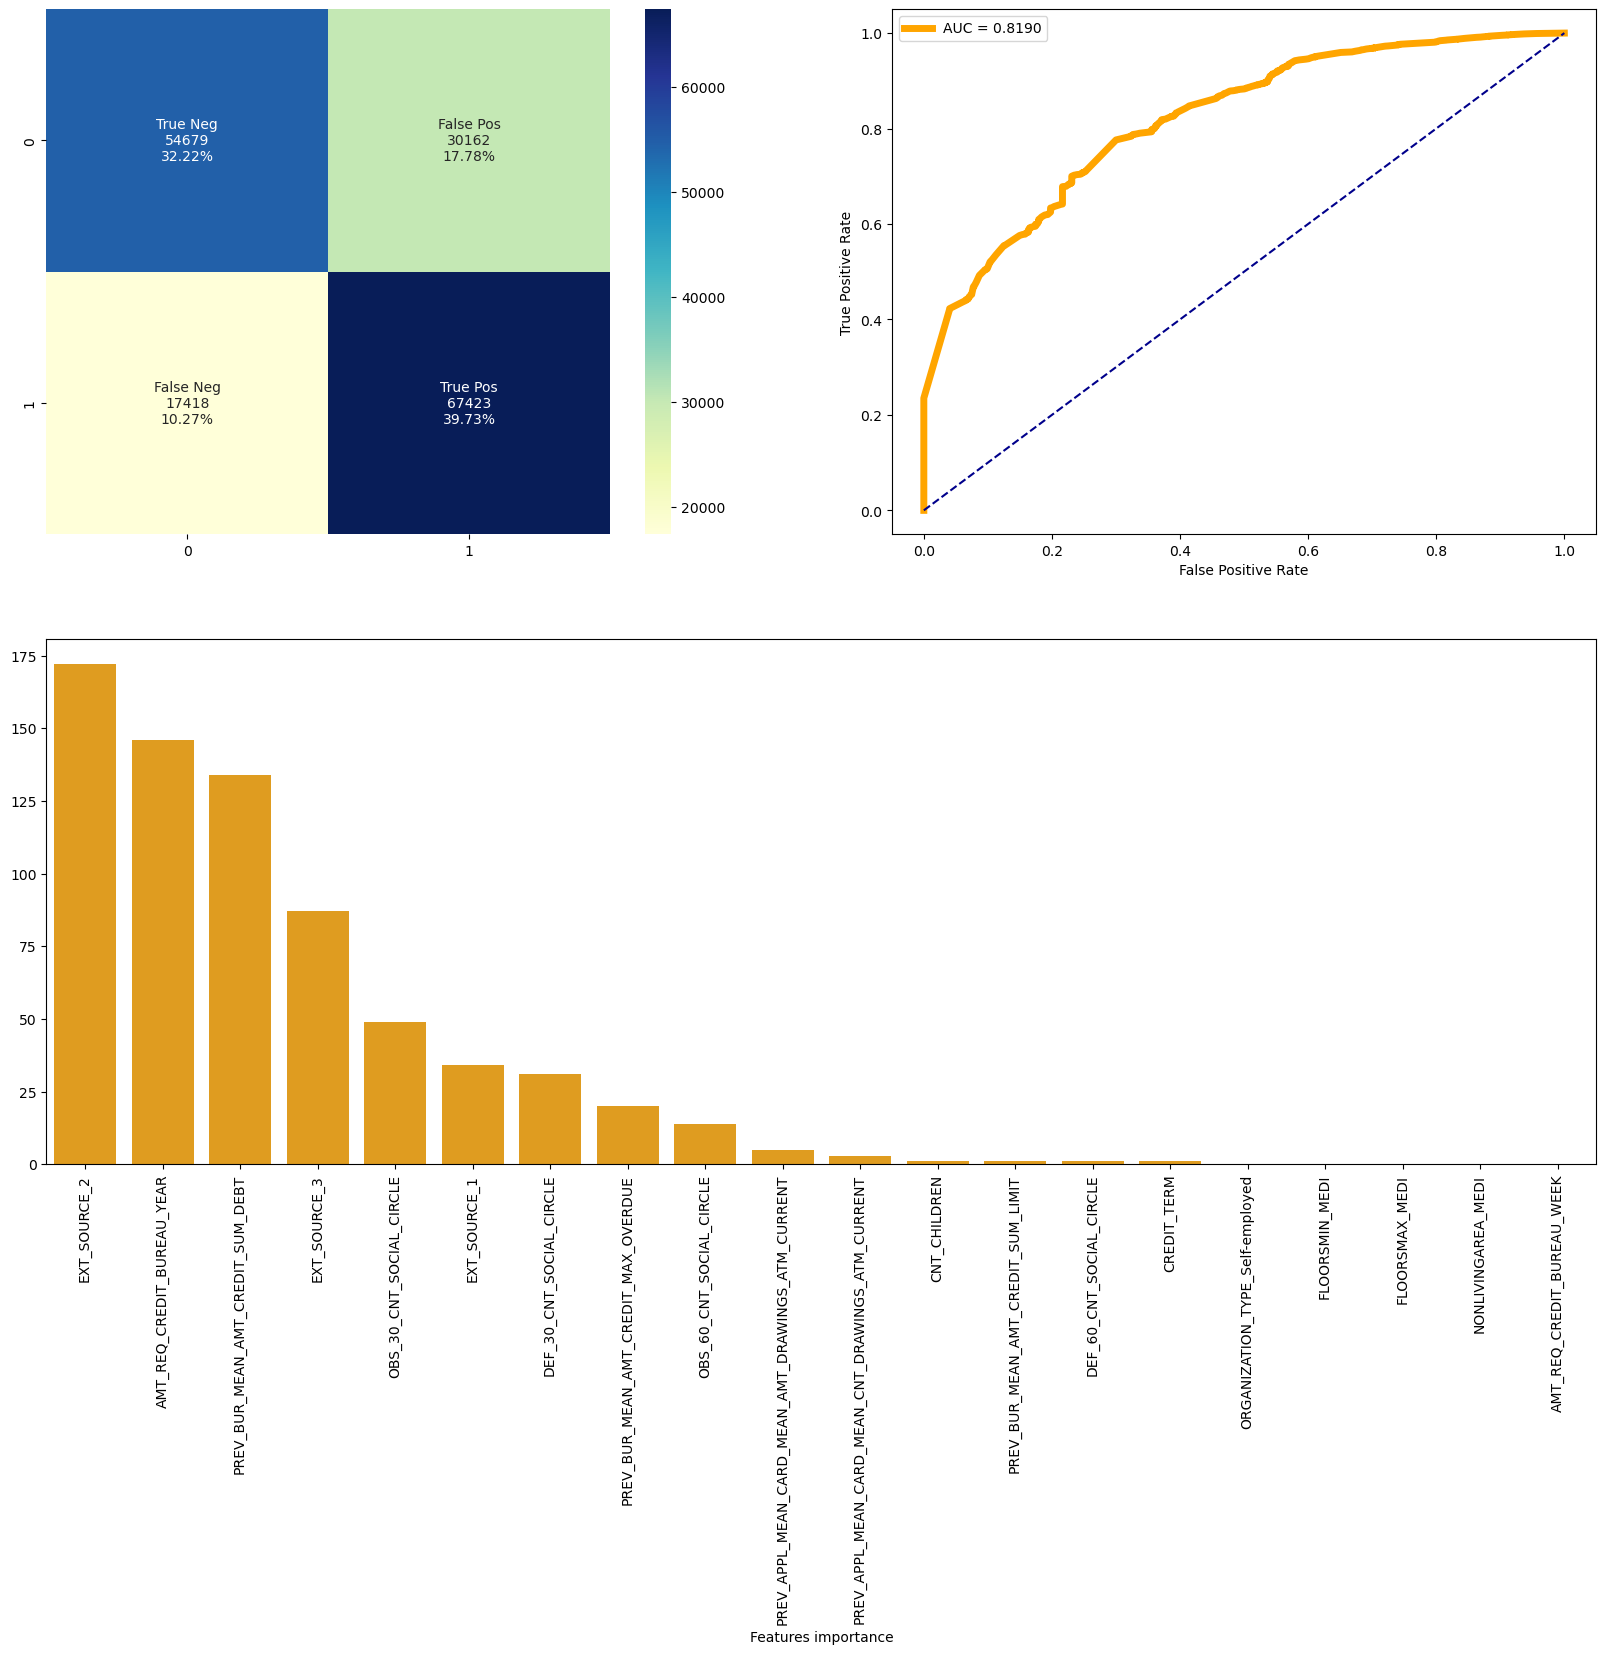

In [49]:
cf_matrix_roc_auc(lgbm, y_test_res, lgbm.predict(X_test_selected), 
                  lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [50]:
#FP and FN
cost_false(lgbm, y_test_res, X_test_selected)

False Pos: 17.78%
False Neg: 10.27%


(0.17775603776475996, 0.10265084098490117)